<a href="https://colab.research.google.com/github/plaban1981/DEEP-LEARNING-/blob/master/Bidirectional_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bidirectional RNN for Digit Classification**

In this tutorial we will learn how to write code for designing a Bidirectional Recurrent Neural Network (BRNN) in TensorFlow for classifying MNIST digits

**1. Import the required libraries:**

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn


http://ataspinar.com/2018/07/05/building-recurrent-neural-networks-in-tensorflow/

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/recurrent_network.py

https://medium.com/machine-learning-algorithms/mnist-using-recurrent-neural-network-2d070a5915a2

https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-2-f7e5ece849f5

http://www.easy-tensorflow.com/tf-tutorials/recurrent-neural-networks/bidirectional-rnn-for-classification

**Load the MNIST data**

The dataset contains 55,000 examples for training, 5,000 examples for validation and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

To classify images using a recurrent neural network, we consider every image row as a sequence of pixels. Because MNIST image shape is 28x28 pixels, we will then handle 28 sequences of 28 timesteps for every sample.

In [37]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
x_train, y_train, x_valid, y_valid = mnist.train.images, mnist.train.labels,mnist.validation.images, mnist.validation.labels
x_test, y_test = mnist.test.images, mnist.test.labels


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [39]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(55000, 784)
(5000, 784)
(10000, 784)


**Data Dimensions**

In [0]:
# Data Dimension
num_input = 28          # MNIST data input (image shape: 28x28)
timesteps = 28          # Timesteps
n_classes = 10          # Number of classes, one class per digit

**Hyperparameters**

In [0]:
learning_rate = 0.001 # The optimization initial learning rate
epochs = 10           # Total number of training epochs
batch_size = 100      # Training batch size
display_freq = 100    # Frequency of displaying the training results


**Network configuration**

In [0]:
num_hidden_units = 128  # Number of hidden units of the RNN

**Create network helper functions**

In [0]:
# weight and bais wrappers
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W',
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b',
                           dtype=tf.float32,
                           initializer=initial)

**Helper-function for creating a Bidirectional RNN**

In [0]:
tf.reset_default_graph()

In [0]:
def BiRNN(x, weights, biases, timesteps, num_hidden):
    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, num_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, num_input)
    x = tf.unstack(x, timesteps, 1)

    # Define lstm cells with tensorflow
    # Forward direction cell
    lstm_fw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    # Backward direction cell
    lstm_bw_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get BiRNN cell output
    outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                                 dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights) + biases

**Create the network graph**

In [0]:
# Placeholders for inputs (x) and outputs(y)
x = tf.placeholder(tf.float32, shape=[None, timesteps, num_input], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

**Define the network**

In [0]:
# create weight matrix initialized randomely from N~(0, 0.01)
W = weight_variable(shape=[2*num_hidden_units, n_classes])

# create bias vector initialized as zero
b = bias_variable(shape=[n_classes])

output_logits = BiRNN(x, W, b, timesteps, num_hidden_units)
y_pred = tf.nn.softmax(output_logits)
 

**Define the loss function, optimizer, accuracy, and predicted class**

In [0]:
# Model predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

# Define the loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

**Initialize all variables**

In [0]:
# Creating the op for initializing all variables
init = tf.global_variables_initializer()

In [0]:
def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

**Train**

In [61]:
sess = tf.InteractiveSession()
sess.run(init)
global_step = 0
# Number of training iterations in each epoch
num_tr_iter = int(len(y_train) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)
        x_batch = x_batch.reshape((batch_size, timesteps, num_input))
        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict=feed_dict_batch)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch

    feed_dict_valid = {x: x_valid[:1000].reshape((-1, timesteps, num_input)), y: y_valid[:1000]}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Training epoch: 1
iter   0:	 Loss=2.30,	Training Accuracy=20.0%
iter 100:	 Loss=0.94,	Training Accuracy=75.0%
iter 200:	 Loss=0.80,	Training Accuracy=75.0%
iter 300:	 Loss=0.43,	Training Accuracy=84.0%
iter 400:	 Loss=0.33,	Training Accuracy=91.0%
iter 500:	 Loss=0.27,	Training Accuracy=91.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.23, validation accuracy: 93.5%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.22,	Training Accuracy=93.0%
iter 100:	 Loss=0.29,	Training Accuracy=90.0%
iter 200:	 Loss=0.15,	Training Accuracy=95.0%
iter 300:	 Loss=0.25,	Training Accuracy=92.0%
iter 400:	 Loss=0.22,	Training Accuracy=94.0%
iter 500:	 Loss=0.11,	Training Accuracy=97.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.14, validation accuracy: 96.1%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.09,	Training Accuracy=98

**Test**

 Helper functions for plotting the results

In [0]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(np.squeeze(images[i]).reshape(28, 28), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)

def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

**Run the test and plot some results**

---------------------------------------------------------
Test loss: 0.07, test accuracy: 97.9%
---------------------------------------------------------


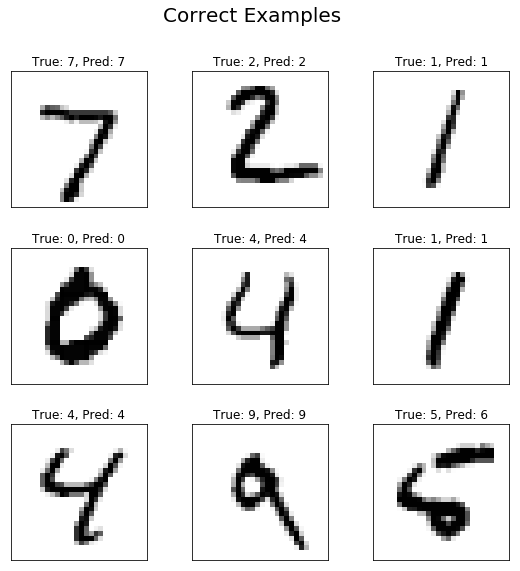

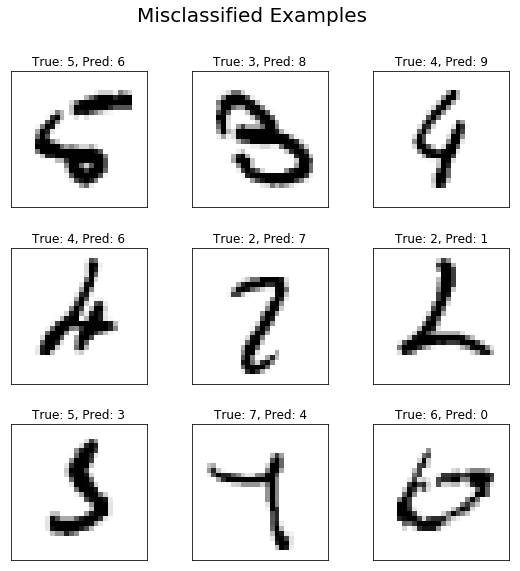

In [63]:
feed_dict_test = {x: x_test[:1000].reshape((-1, timesteps, num_input)), y: y_test[:1000]}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test, axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test[:1000], cls_true[:1000], cls_pred, title='Misclassified Examples')
plt.show()
 